In [1]:
import tkinter as tk
from tkinter import filedialog
import numpy as np  
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import cv2 
import pandas as pd
from skimage.metrics import structural_similarity as ssim
import pywt
from tabulate import tabulate

## Functions ##

In [2]:
def select_images():
    root = tk.Tk()
    root.wm_attributes('-topmost', 1)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select Image Files", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif")])

    images = []
    if file_paths:
        for file_path in file_paths:
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)
            images.append(image)
    return images

In [3]:
def create_mosaic(images):
    def img_norm(img):
        return img/img.max() # Normalize values
    
    if len(images) == 1: # if only one image in a list ,return original image
        return images[0]
    elif len(images) <= 4: # if 4 images in a list,create mosaic 
        block1 = np.block([[img_norm(images[0]), img_norm(images[2])], [img_norm(images[1]), img_norm(images[3])]])
        return block1
    else: # if more than 4 images ,recursively apply this function on LL 
        return np.block([[img_norm(create_mosaic(images[4:])),img_norm(images[2])], [img_norm(images[1]), img_norm(images[3])]])

In [4]:
def MRDCT(image, level=1):
    """
    Perform Multi Resolution DCT on an image
    
    Parameters:
    image: ndarray
        The input image as a numpy array
    level: int, optional (default=1)
        The number of decomposition levels to perform
        
    Returns:
    coeffs: list
        A list of numpy arrays containing the IDCT coefficients [LL_1,LH_1,HL_1,HH_1,LL_2,LH_2,HL_2,HH_2,etc...]
    """
    coeffs = []
    
    for i in range(level):
        # Perform DCT on columns
        dct_cols = dct(image, axis=0,type=2, norm='ortho')
        
        # Split into upper and lower halves along rows
        split_row = dct_cols.shape[0] // 2
        upper_half = dct_cols[:split_row, :]
        lower_half = dct_cols[split_row:, :]
        
        # Perform IDCT on each half along columns
        idct_upper = idct(upper_half, axis=0,type=2, norm='ortho')
        idct_lower = idct(lower_half, axis=0,type=2, norm='ortho')
        
        # Combine the halves and perform DCT on rows
        dct_rows_upper = dct(idct_upper, axis=1,type=2, norm='ortho')
        dct_rows_lower = dct(idct_lower, axis=1,type=2, norm='ortho')

        # Split into LL, LH, HL, HH coefficients
        split_col_u = dct_rows_upper.shape[1] // 2
        split_col_l = dct_rows_lower.shape[1] // 2
        LL_f = dct_rows_upper[:, :split_col_u]
        LH_f = dct_rows_upper[:, split_col_u:]
        HL_f = dct_rows_lower[:, :split_col_l]
        HH_f = dct_rows_lower[:, split_col_l:]
        LL = idct(LL_f, axis=1,type=2, norm='ortho')
        LH = idct(LH_f, axis=1,type=2, norm='ortho')
        HL = idct(HL_f, axis=1,type=2, norm='ortho')
        HH = idct(HH_f, axis=1,type=2, norm='ortho')
        
        # Append the coefficients to the list
        coeffs.append(LL)
        coeffs.append(LH)
        coeffs.append(HL)
        coeffs.append(HH)
        # Update the image for the next level
        image = LL.copy()
    return coeffs 

In [5]:
def IMRDCT(coeff):
    """
    Perform Multi Resolution IDCT on a coeeficents
    
    Parameters:
    image: list of ndarray
         A list of numpy arrays containing the IDCT coefficients [LL_1,LH_1,HL_1,HH_1,LL_2,LH_2,HL_2,HH_2,etc...]
   
    Returns:
         LL:image as a numpy array
        
    """ 
    batches = []
    for i in range(0, len(coeff), 4): # split images list to batches for each level
        batches.append(coeff[i:i+4])
    batches =batches[::-1] # revert list of batches 

    def block_LL(LL_I,LH_I,HL_I,HH_I): # assembly block for one level
        LL = dct(LL_I, axis=1,type=2, norm='ortho')
        LH = dct(LH_I, axis=1,type=2, norm='ortho')
        HL = dct(HL_I, axis=1,type=2, norm='ortho')
        HH = dct(HH_I, axis=1,type=2, norm='ortho')
        block_up_col = idct(np.block([LL ,LH]),axis=1,type=2, norm='ortho')
        block_low_col = idct(np.block([HL ,HH]), axis=1,type=2, norm='ortho')
        block_up_row = dct(block_up_col,axis=0,type=2, norm='ortho')
        block_low_col = dct(block_low_col, axis=0,type=2, norm='ortho')
        block1=idct(np.block([[block_up_row],[block_low_col]]), axis=0,type=2, norm='ortho')
        return block1
    
    LL = []
    if len(batches)==1: # if only one level 
        return block_LL(batches[0][0],batches[0][1],batches[0][2],batches[0][3])
    else: # if multiple levels ,apply assembly recursively
        for i,val in enumerate(batches):
            if i==0:
               LL.append(block_LL((val[0]),val[1],val[2],val[3]))   
            else:   
               LL.append(block_LL(LL[i-1],val[1],val[2],val[3]))   
        return LL[-1]

In [6]:
###Wavalets
def MRWT(image, level,wavelet):
    """
    Perform Multi Resolution DWT on an image
    
    Parameters:
    image: ndarray
        The input image as a numpy array
    level: int, optional (default=1)
        The number of decomposition levels to perform
    wavelet: Mother wavelet     
    Returns:
    coeffs: list
        A list of numpy arrays containing the IWCT coefficients [LL_1,LH_1,HL_1,HH_1,LL_2,LH_2,HL_2,HH_2,etc...]
    """
    coeffs = []
    
    for i in range(level):
        coeffs2 = pywt.dwt2(image, wavelet)
        LL, (LH, HL, HH) = coeffs2
        # Append the coefficients to the list
        coeffs.append(LL)
        coeffs.append(LH)
        coeffs.append(HL)
        coeffs.append(HH)
        # Update the image for the next level
        image = LL.copy()

    return coeffs 

In [7]:
def IMRWT(coeff,wavelet): 
    """
    Perform Multi Resolution IDWT on a coeeficents
    
    Parameters:
    image: list of ndarray
         A list of numpy arrays containing the IDCT coefficients [LL_1,LH_1,HL_1,HH_1,LL_2,LH_2,HL_2,HH_2,etc...]
    wavelet: Mother wavelet   
    Returns:
         LL:image as a numpy array
        
    """ 
    batches = []
    for i in range(0, len(coeff), 4):
        batches.append(coeff[i:i+4])
    batches =batches[::-1]

    def block_LL(LL_I,LH_I,HL_I,HH_I,wavelet):
        return pywt.idwt2((LL_I, (LH_I,HL_I,HH_I)), wavelet)  
      
    LL = []
    if len(batches)==1:
        return block_LL(batches[0][0],batches[0][1],batches[0][2],batches[0][3],wavelet)
    else: 
        for i,val in enumerate(batches):
            if i==0:
               LL.append(block_LL((val[0]),val[1],val[2],val[3],wavelet))   
            else:   
               LL.append(block_LL(LL[i-1],val[1],val[2],val[3],wavelet))   
        return LL[-1]

In [8]:
def fusion_dct(img_1,img_2,level,details,approx,display_decomposition_mosaic=False ,display_fusion_mosaic=False,display_fusion=False,err=False):
    def get_max_magnitude_pixel(A, B):
        # Ensure images are of the same shape
        assert A.shape == B.shape
        A = A.astype(np.float32)
        B = B.astype(np.float32)
        # Calculate the magnitude of each pixel in the images
        mag1 = np.abs(A)
        mag2 = np.abs(B)
        
        # Determine which image has the higher magnitude pixel for each location
        higher_mag_mask = mag1 > mag2
        
        # Combine the masks with the original images to obtain the maximum magnitude pixels
        max_pixels = np.zeros_like(A)
        max_pixels[higher_mag_mask] = A[higher_mag_mask]
        max_pixels[~higher_mag_mask] = B[~higher_mag_mask]
        
        # Return the maximum magnitude pixels
        return max_pixels

    def get_min_magnitude_pixel(A, B):
        # Ensure images are of the same shape
        assert A.shape == B.shape
        A = A.astype(np.float32)
        B = B.astype(np.float32)
        # Calculate the magnitude of each pixel in the images
        mag1 = np.abs(A)
        mag2 = np.abs(B)
        
        # Determine which image has the smaller magnitude pixel for each location
        lower_mag_mask = mag1 < mag2
        
        # Combine the masks with the original images to obtain the minimum magnitude pixels
        min_pixels = np.zeros_like(A)
        min_pixels[lower_mag_mask] = A[lower_mag_mask]
        min_pixels[~lower_mag_mask] = B[~lower_mag_mask]
        
        # Return the minimum magnitude pixels
        return min_pixels
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_RBUTTONUP:
            cv2.destroyAllWindows()
    coeff =[]
    coeffs_1 = MRDCT(img_1,level)
    coeffs_2 = MRDCT(img_2,level)
    for i, val in enumerate(coeffs_1): # Fusion
        if i % 4 == 0 :
            if approx =='min': 
                coeff.append(get_min_magnitude_pixel(coeffs_2[i],coeffs_1[i]))
            elif approx == 'max':
                coeff.append(get_max_magnitude_pixel(coeffs_2[i],coeffs_1[i]))      
            else:
                mean_coeff = (coeffs_1[i]+coeffs_2[i])/2
                coeff.append(mean_coeff)
        else:
            if details == 'min':
                coeff.append(get_min_magnitude_pixel(coeffs_2[i],coeffs_1[i]))
            elif details == 'max':
                coeff.append(get_max_magnitude_pixel(coeffs_2[i],coeffs_1[i]))
            elif details == 'mean':
                #coeff.append(np.mean(np.array([coeffs_1[i],coeffs_2[i]]),axis=0))
                mean_coeff = (coeffs_1[i]+coeffs_2[i])/2
                coeff.append(mean_coeff)
            else:
                print("Invalid metric for details")
    MRDCT1 = create_mosaic(coeffs_1)  
    MRDCT2 = create_mosaic(coeffs_2)
    MRDCT_FUSION = create_mosaic(coeff)     
    IMRDCT_FUSION = IMRDCT(coeff)

    if display_decomposition_mosaic:
        combined_i = cv2.hconcat([MRDCT1,MRDCT2])
        cv2.putText(combined_i, 'IDCT_IMG1', (220, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(combined_i, 'IDCT_IMG2', (MRDCT1.shape[1]+220, 480), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 1)
        cv2.imshow(f'Decomposition level: {level}',combined_i)
        cv2.setWindowProperty(f'Decomposition level: {level}', cv2.WND_PROP_TOPMOST, 1)
        # Associate the callback function with the named window
        cv2.setMouseCallback(f'Decomposition level: {level}', mouse_callback)  
    if display_fusion_mosaic: 
        cv2.putText(MRDCT_FUSION, f'Approx: {approx} Details: {details}', (165, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow(f'Decomposition of Fusion ,level: {level}',MRDCT_FUSION)
        cv2.setWindowProperty(f'Decomposition of Fusion ,level: {level}', cv2.WND_PROP_TOPMOST, 1)
        # Associate the callback function with the named window
        cv2.setMouseCallback(f'Decomposition of Fusion ,level: {level}', mouse_callback)  
    if display_fusion:
        cv2.putText(IMRDCT_FUSION, f'Approx: {approx} Details: {details}', (165, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.imshow('Fusion',IMRDCT_FUSION.copy()/255.)
        cv2.setWindowProperty('Fusion', cv2.WND_PROP_TOPMOST, 1)
        # Associate the callback function with the named window
        cv2.setMouseCallback('Fusion', mouse_callback)  
    if not err:
        cv2.waitKey(0)
        cv2.destroyAllWindows()     
    return IMRDCT(coeff),coeff,MRDCT1,MRDCT2,create_mosaic(coeff)

In [9]:
def fusion_dwt(img_1,img_2,level,wavelet,details,approx,display_decomposition_mosaic=False ,display_fusion_mosaic=False,display_fusion=False ,err=False):
    def get_max_magnitude_pixel(A, B):
        # Ensure images are of the same shape
        assert A.shape == B.shape
        A = A.astype(np.float32)
        B = B.astype(np.float32)
        # Calculate the magnitude of each pixel in the images
        mag1 = np.abs(A)
        mag2 = np.abs(B)
        
        # Determine which image has the higher magnitude pixel for each location
        higher_mag_mask = mag1 > mag2
        
        # Combine the masks with the original images to obtain the maximum magnitude pixels
        max_pixels = np.zeros_like(A)
        max_pixels[higher_mag_mask] = A[higher_mag_mask]
        max_pixels[~higher_mag_mask] = B[~higher_mag_mask]
        
        # Return the maximum magnitude pixels
        return max_pixels

    def get_min_magnitude_pixel(A, B):
        # Ensure images are of the same shape
        assert A.shape == B.shape
        A = A.astype(np.float32)
        B = B.astype(np.float32)
        # Calculate the magnitude of each pixel in the images
        mag1 = np.abs(A)
        mag2 = np.abs(B)
        
        # Determine which image has the smaller magnitude pixel for each location
        lower_mag_mask = mag1 < mag2
        
        # Combine the masks with the original images to obtain the minimum magnitude pixels
        min_pixels = np.zeros_like(A)
        min_pixels[lower_mag_mask] = A[lower_mag_mask]
        min_pixels[~lower_mag_mask] = B[~lower_mag_mask]
        
        # Return the minimum magnitude pixels
        return min_pixels
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_RBUTTONUP:
            cv2.destroyAllWindows()
        
    coeff =[]
    coeffs_1 = MRWT(img_1,level,wavelet)
    coeffs_2 = MRWT(img_2,level,wavelet)
    for i, val in enumerate(coeffs_1):
        if i % 4 == 0 :
            if approx =='min':
                coeff.append(get_min_magnitude_pixel(coeffs_1[i],coeffs_2[i]))
            elif approx == 'max':
                coeff.append(get_max_magnitude_pixel(coeffs_1[i],coeffs_2[i]))      
            else:
                mean_coeff = (coeffs_1[i]+coeffs_2[i])/2
                coeff.append(mean_coeff)
        else:
            # Compare the magnitudes of the matrices using the specified metric
            if details == 'min':
                coeff.append(get_min_magnitude_pixel(coeffs_1[i],coeffs_2[i]))
            elif details == 'max':
                coeff.append(get_max_magnitude_pixel(coeffs_1[i],coeffs_2[i]))
            elif details == 'mean':
                #coeff.append(np.mean(np.array([coeffs_1[i],coeffs_2[i]]),axis=0))
                mean_coeff = (coeffs_1[i]+coeffs_2[i])/2
                coeff.append(mean_coeff)
            else:
                print("Invalid metric for details")
    MRWT1 = create_mosaic(coeffs_1)  
    MRWT2 = create_mosaic(coeffs_2)
    MRWT_FUSION = create_mosaic(coeff)     
    IMRWT_FUSION = IMRWT(coeff,wavelet)
    if display_decomposition_mosaic:
        combined_i = cv2.hconcat([MRWT1,MRWT2])
        cv2.putText(combined_i, 'IDWT_IMG1', (220, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(combined_i, 'IDWT_IMG2', (MRWT1.shape[1]+220, 480), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 1)
        cv2.imshow(f'Decomposition level: {level}',combined_i)
        cv2.setWindowProperty(f'Decomposition level: {level}', cv2.WND_PROP_TOPMOST, 1)
        cv2.setMouseCallback(f'Decomposition level: {level}', mouse_callback) 
    if display_fusion_mosaic: 
        cv2.putText(MRWT_FUSION, f'Mother Wavelet: {wavelet} Approx: {approx} Details: {details}', (70, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow(f'Decomposition of Fusion ,level: {level}',MRWT_FUSION)
        cv2.setWindowProperty(f'Decomposition of Fusion ,level: {level}', cv2.WND_PROP_TOPMOST, 1)
        # Associate the callback function with the named window
        cv2.setMouseCallback(f'Decomposition of Fusion ,level: {level}', mouse_callback) 
    if display_fusion:
        cv2.putText(IMRWT_FUSION, f'Approx: {approx} Details: {details}', (165, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.imshow('Fusion',IMRWT_FUSION/255.)
        cv2.setWindowProperty('Fusion', cv2.WND_PROP_TOPMOST, 1)
        # Associate the callback function with the named window
        cv2.setMouseCallback('Fusion', mouse_callback)
    if not err:       
        cv2.waitKey(0)
        cv2.destroyAllWindows()    
    return IMRWT(coeff,wavelet),coeff,MRWT1,MRWT2,create_mosaic(coeff) 

In [117]:
# metrics 
def PFE(I_r, I_f):
    norm_diff = np.linalg.norm(I_r - I_f)
    norm_I_r = np.linalg.norm(I_r)
    pfe = (norm_diff / norm_I_r) * 100
    return round(pfe ,4)

def PSNR(I_r, I_f):
    mse = np.mean((I_r - I_f) ** 2)
    max_pixel = 255
    psnr = 10 * np.log10(max_pixel**2 /mse) 
    #psnr = 20 * np.log10(max_pixel/np.sqrt(mse))
    return round(psnr, 4)

def SD(I_f):
    # Compute the histogram
    hist, bins = np.histogram(I_f.flatten(),bins=256)
    # Compute the mean of the histogram
    mean = np.sum(hist * bins[:-1]) / np.sum(hist)

    # Compute the variance of the histogram
    variance = np.sum((bins[:-1] - mean) ** 2 * hist) / np.sum(hist)

    # Compute the standard deviation of the histogram
    return round(np.sqrt(variance), 4)

def MSSISM(I_r, I_f,L=255):
    K1 = 0.01
    K2 = 0.03
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    # INITS
    I2_2 = I_f**2 # I2^2
    I1_2 = I_r**2 # I1^2
    I1_I2 = I_r * I_f # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv2.GaussianBlur(I_r, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(I_f, (11, 11), 1.5)
    mu1_2 = mu1 **2
    mu2_2 = mu2 **2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv2.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv2.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv2.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2                    # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2                    # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = t3/t1   
    mssim =np.mean(ssim_map)       # mssim = average of ssim map
    return round(mssim ,4)

def CE(I1,I2,I_f):
    def calculate_pmf(image):
        # Compute the histogram of the image
        hist, _ = np.histogram(image.flatten(), bins=256)

        # Calculate the total number of pixels in the image
        num_pixels = np.sum(hist)

        # Calculate the PMF by dividing each bin in the histogram by the total number of pixels
        pmf = hist / num_pixels

        return pmf
    def crossEntropy(Y, P):
        epsilon= 2**(-32)
        hist_y = calculate_pmf(Y)
        hist_p = calculate_pmf(P)
        # Add epsilon to avoid division by zero errors
        hist_y = np.clip(hist_y, epsilon, 1)
        hist_p = np.clip(hist_p, epsilon, 1)
        CE = np.sum(hist_y*np.log(hist_y/hist_p))
        return CE
    return  round((crossEntropy(I1, I_f) + crossEntropy(I2, I_f))*0.5 ,4)

def SF(I_f):
    def RF(X):
        result = []
        for i in range(len(X)):
            row = []
            for j in range(1, len(X[i])):
                row.append((X[i][j] - X[i][j-1])**2)
            result.append(row)
        return np.sum(result)/(X.shape[0]*X.shape[1])
    
    def CF(X):
        result = []
        for i in range(1, len(X)):
            row = []
            for j in range(len(X[i])):
                row.append((X[i][j] - X[i-1][j])**2)
            result.append(row)
        return np.sum(result)/(X.shape[0]*X.shape[1])

    sf = np.sqrt(RF(I_f) + CF(I_f))
    return round(sf ,4)

In [11]:
def dict_to_table(data,fusion,level):
    df = pd.DataFrame(data.items(), columns=['Fusion: '+fusion+' Level: '+ str(level), 'Metric Value'])
    table = tabulate(df, headers='keys', tablefmt='psql', showindex=False)
    print(table)

In [12]:
def fusion(images,level,fusion,wavelet,details,approx,display_decomposition_mosaic=False ,display_fusion_mosaic=False,display_fusion=False,display_error=False,calculate_metrics =False):
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_RBUTTONUP:
            cv2.destroyAllWindows()
            
    img_1 = images[0]
    img_2 = images[1]
    if len(images)>2:
        reference_img = images[2]
    
    if fusion =='DCT':
       out,_,_,_,_ = fusion_dct(img_1,img_2,level,details,approx,display_decomposition_mosaic,display_fusion_mosaic,display_fusion,err=display_error)
    elif fusion =='DWT':
       out,_,_,_,_ =fusion_dwt(img_1,img_2,level,wavelet,details,approx,display_decomposition_mosaic,display_fusion_mosaic,display_fusion,err=display_error)
    else:
        print('Error')
    
    if display_error:
        # Plot error Image
        cv2.imshow('Error',(out-reference_img)/255.) 
        cv2.setMouseCallback('Error', mouse_callback)  
        cv2.waitKey(0)
        cv2.destroyAllWindows()

     # Perform Metrics
    if calculate_metrics:
        info_no_ref = {'CE':CE(img_1,img_2,out),'SD': SD(out),'SF':SF(out)}
        if len(images)>2:
            info_ref={'PFE': PFE(reference_img,out) , 'PSNR' :PSNR(reference_img,out),
                    'SSIM': MSSISM(reference_img,out,L=255)}        
            info = {**info_ref,**info_no_ref}
        else:
            info =info_no_ref 
        dict_to_table(info,fusion,level)
        return info

In [13]:
def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_RBUTTONUP:
            cv2.destroyAllWindows()

### Test od IMRDCT AND MRDCT


In [38]:
images = select_images()
image=images[0]
coeffs = MRDCT(image, level=9)
h=IMRDCT(coeffs)

In [39]:
cv2.imshow('Decomposition',create_mosaic(coeffs))
cv2.waitKey(0)
cv2.destroyAllWindows()

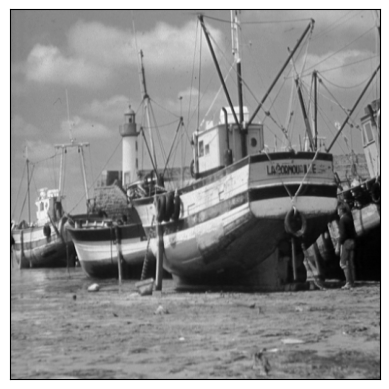

In [40]:
plt.imshow(h,cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)  
plt.show()

In [41]:
cv2.imshow('k',np.abs(h-image)/255.)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [43]:
error = np.abs(h-image)
describe = f'Original (max,min): ({image.min()} {image.max()}) , Reconstructed (max,min): ({h.min()} {h.max()} ,|Orig-Rec| (max,min): ({error.min()} {error.max()})'
print(describe)

Original (max,min): (7.0 244.0) , Reconstructed (max,min): (6.999982833862305 243.99961853027344 ,|Orig-Rec| (max,min): (0.0 0.00067138671875)


### Test od IMRDWT AND MRDWT

In [49]:
images = select_images()
image=images[0]
coeff = MRWT(image, level=1,wavelet='haar')
k=IMRWT(coeff,wavelet='haar')

In [51]:
cv2.imshow('Decomposition',create_mosaic(coeff))
cv2.waitKey(0)
cv2.destroyAllWindows()

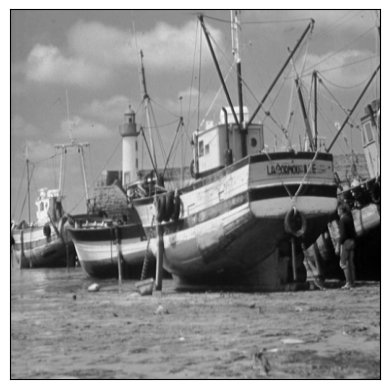

In [50]:
plt.imshow(k,cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)  
plt.show()

In [52]:
error = np.abs(k-image)
describe = f'Original (max,min): ({image.min()} {image.max()}) , Reconstructed (max,min): ({k.min()} {k.max()} ,|Orig-Rec| (max,min): ({error.min()} {error.max()})'
print(describe)

Original (max,min): (7.0 244.0) , Reconstructed (max,min): (7.0 244.0 ,|Orig-Rec| (max,min): (0.0 6.103515625e-05)


## Load Images and Create Fusion  

In [55]:
images = select_images()
image_1= images[0]
image_2= images[1]
if len(images)>2:
   reference_img = images[2]
   cv2.imshow('Unfocudes and Reference Images',cv2.hconcat([image_1,image_2,reference_img])/255.) 
   cv2.setMouseCallback('Unfocudes and Reference Images', mouse_callback)  
else:
   cv2.imshow('Unfocudes Images',cv2.hconcat([image_1,image_2])/255.) 
   cv2.setMouseCallback('Unfocudes Images', mouse_callback)      
cv2.waitKey(0)
cv2.destroyAllWindows()

In [56]:
info = fusion(images,level=1,fusion = 'DWT',wavelet='haar',approx='mean',details='max',display_decomposition_mosaic=False ,display_fusion_mosaic=False,display_fusion=False,display_error=False,calculate_metrics =True)

+------------------------+----------------+
| Fusion: DWT Level: 1   |   Metric Value |
|------------------------+----------------|
| PFE                    |         3.558  |
| PSNR                   |        29.7743 |
| SSIM                   |         0.9737 |
| CE                     |         7.2569 |
| SD                     |        46.2713 |
| SF                     |        10.4643 |
+------------------------+----------------+


In [112]:
out,coeffs,_,_,_ =fusion_dct(image_1,image_2,level=1,details='max',approx='mean',display_decomposition_mosaic=True, display_fusion_mosaic=True, display_fusion=True, err=False)

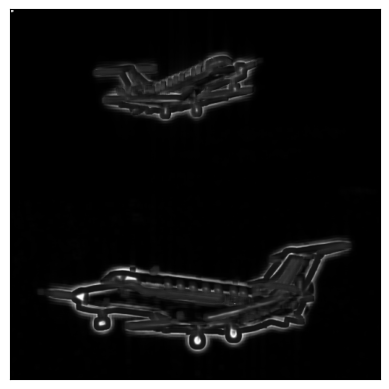

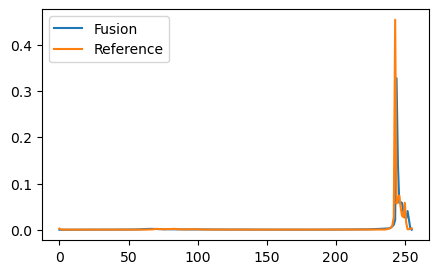

0.9659866553945067

In [113]:
score,diff = ssim(reference_img,out,full=True,data_range=255,use_sample_covariance=True)
plt.figure()
plt.imshow(1-diff,cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)  

plt.figure(figsize=(5,3))
hist,bin = np.histogram(out.ravel(), 256)
plt.plot(hist/(512**2))
hist,bin = np.histogram(reference_img.ravel(), 256)
plt.plot(hist/(512**2))
plt.legend(['Fusion','Reference'])
plt.show()
score

In [114]:
out,coeffs,_,_,_ =fusion_dwt(image_1,image_2,level=1,wavelet='haar',details='max',approx='mean',display_decomposition_mosaic=True, display_fusion_mosaic=True, display_fusion=True, err=False)

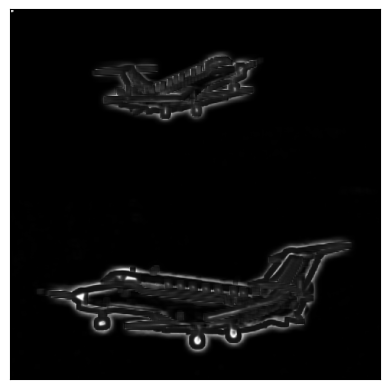

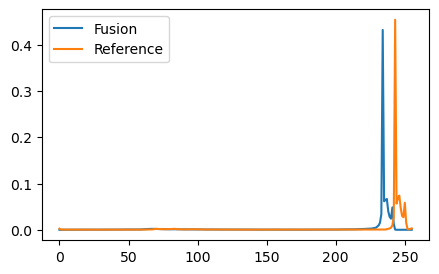

0.9695847739266653

In [115]:
score,diff = ssim(reference_img,out,full=True,data_range=255,use_sample_covariance=True)
plt.figure()
plt.imshow(1-diff,cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)  

plt.figure(figsize=(5,3))
hist,bin = np.histogram(out.ravel(), 256)
plt.plot(hist/(512**2))
hist,bin = np.histogram(reference_img.ravel(), 256)
plt.plot(hist/(512**2))
plt.legend(['Fusion','Reference'])
plt.show()
score

In [118]:
# Perform Metrics
info_no_ref = {'SD': SD(out),'SF':SF(out)}
if len(images)>2:
    info_ref={'PFE': PFE(reference_img,out) , 'PSNR' :PSNR(reference_img,out),
              'SSIM': MSSISM(reference_img,out,L=255),'CE':CE(image_1,image_2,out)}        
    info = {**info_ref,**info_no_ref}
else:
    info =info_no_ref 
print(info) 

{'PFE': 3.558, 'PSNR': 29.7743, 'SSIM': 0.9737, 'CE': 7.2569, 'SD': 46.2713, 'SF': 10.4643}


### GUI Test

In [54]:
import tkinter.ttk
from tkinter import filedialog
images = None

def select_images_from_folder():
    global images
    file_paths = filedialog.askopenfilenames(title="Select Image Files", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif")])
    print(file_paths)
    images = []
    if file_paths:
        for file_path in file_paths:
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)
            images.append(image)
    enable_btn()   
    return images

def start_fusion(display_fusion=False,display_fusion_mosaic=False,display_decomposition_mosaic=False,display_error = False,calculate_metrics=False):

    global images

    if len(images) >= 2:

        details_param = details_combo.get()
        approx_param = approximation_combo.get()
        dwt_param = dwt_selected_combo.get()
        fusion_param = fusion_model_combo.get()
        level_param = int(decomposition_level_scale.get())
        
        info = fusion(images,level_param, fusion_param, dwt_param, details_param,approx_param, display_fusion, display_fusion_mosaic, display_decomposition_mosaic, display_error,calculate_metrics)
        insert_data_to_metric_table(info)

def display_selected_images():
    global images
    if len(images)>2:
        image_1= images[0]
        image_2= images[1]
        reference_img = images[2]
        cv2.imshow('Unfocudes and Reference Images',cv2.hconcat([image_1,image_2,reference_img])/255.) 
        cv2.setMouseCallback('Unfocudes and Reference Images', mouse_callback)
          
    elif len(images)==2:
        image_1= images[0]
        image_2= images[1]
        cv2.imshow('Unfocudes Images',cv2.hconcat([image_1,image_2])/255.) 
        cv2.setMouseCallback('Unfocudes Images', mouse_callback)  
    else:
        print('Select at least two image')        
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def enable_btn():
    global images
    if len(images)<2 or len(images)>3:
        display_error_btn.config(state='disabled')
        display_selected_images_btn.config(state='disabled')
        display_calculate_metrics_btn.config(state='disabled')
        display_decomposition_btn.config(state='disabled')
        display_fusion_btn.config(state='disabled')
        display_fusion_decomposition_btn.config(state='disabled')
        
    elif len(images)==2:
        display_error_btn.config(state='disabled')
        display_selected_images_btn.config(state='normal')
        display_calculate_metrics_btn.config(state='normal')
        display_decomposition_btn.config(state='normal')
        display_fusion_btn.config(state='normal')
        display_fusion_decomposition_btn.config(state='normal') 
    else:
        display_error_btn.config(state='normal')
        display_selected_images_btn.config(state='normal')
        display_calculate_metrics_btn.config(state='normal')
        display_decomposition_btn.config(state='normal')
        display_fusion_btn.config(state='normal')
        display_fusion_decomposition_btn.config(state='normal')    

def display_decomposition():
    print("display decomposition")

def update_decomposition_label(event):

    val = int(decomposition_level_scale.get())
    decomposition_level_label.config(text=str(val))

def enable_kernel_selection(event):

    current_fusion_model = fusion_model_combo.get()

    if current_fusion_model == "DWT":
        dwt_selected_combo.config(state="readonly")
    else:
        dwt_selected_combo.config(state="disabled")


def display_fusion():
    print("display fusion")


def insert_data_to_metric_table(info):
    for i in metric_table_treeview.get_children():
        metric_table_treeview.delete(i)
    for idx, (key, value) in enumerate(info.items()):
        metric_table_treeview.insert(parent='', index='end', iid=str(idx), values=(key, value))
    cv2.waitKey(0)
    cv2.destroyAllWindows()     


if __name__ == '__main__':

    window = tkinter.Tk()
    window.title("Discrete Cosine Transform-based Image Fusion")
    w = 520
    h = 440
    # limit the window (to be un-resizable)
    window.minsize(w, h)
    window.maxsize(w, h)
    # open window in the center of screen
    screen_width = window.winfo_screenwidth()  # get the screen width
    screen_height = window.winfo_screenheight()  # get the screen height
    x = int((screen_width / 2) - (w / 2))
    y = int((screen_height / 2) - (h / 2))
    window.geometry('{}x{}+{}+{}'.format(w, h, x, y))  # window.geometry('wxh+x+y')

    frame0 = tkinter.ttk.Frame(window)
    frame0.grid(row=0, column=0, padx=10, pady=(30, 15), sticky="w")

    frame1 = tkinter.ttk.Frame(window)
    frame1.grid(row=1, column=0, padx=10, pady=15, sticky="w")

    frame2 = tkinter.ttk.Frame(window)
    frame2.grid(row=2, column=0, padx=10, pady=15, sticky="w")

    frame3 = tkinter.ttk.Frame(window)
    frame3.grid(row=3, column=0, padx=10)

    select_images_btn = tkinter.ttk.Button(frame0, text="Select Images\n From Folder", command=select_images_from_folder)
    select_images_btn.grid(row=0, column=0, padx=7)

    fusion_label = tkinter.ttk.Label(frame0, text="Fusion Model: ")
    fusion_label.grid(row=0, column=1, padx=1)

    fusion_values = ["DCT", "DWT"]
    fusion_model_combo = tkinter.ttk.Combobox(frame0, values=fusion_values, width=6, justify='left', state="readonly")
    fusion_model_combo.grid(row=0, column=2, padx=7)
    fusion_model_combo.set(fusion_values[0])
    fusion_model_combo.bind('<<ComboboxSelected>>', enable_kernel_selection)

    decomposition_label = tkinter.ttk.Label(frame0, text="Decomposition Level: ")
    decomposition_label.grid(row=0, column=3, padx=1)

    # decomposition levels (scale widget)
    decomposition_level_scale = tkinter.ttk.Scale(frame0, from_=1, to=8, orient="horizontal", command=update_decomposition_label)
    decomposition_level_scale.grid(row=0, column=4)
    decomposition_level_label = tkinter.ttk.Label(frame0, text='0')
    decomposition_level_label.grid(row=0, column=5)
    decomposition_level_scale.set(1)

    display_selected_images_btn = tkinter.ttk.Button(frame1, text="Display\nSelected Images",state='disabled', command=display_selected_images)
    display_selected_images_btn.grid(row=0, column=0, padx=7)

    kernel_label = tkinter.ttk.Label(frame1, text="Kernel: ")
    kernel_label.grid(row=0, column=1, padx=1)

    dwt_selected_values = ["db1", "haar"]
    dwt_selected_combo = tkinter.ttk.Combobox(frame1, values=dwt_selected_values, width=6, justify='left', state="disabled")
    dwt_selected_combo.grid(row=0, column=2, padx=7)
    dwt_selected_combo.set(dwt_selected_values[0])

    details_label = tkinter.ttk.Label(frame1, text="Details: ")
    details_label.grid(row=0, column=3, padx=1)

    details_values = ["max", "min", "mean"]
    details_combo = tkinter.ttk.Combobox(frame1, values=details_values, width=5, state="readonly")
    details_combo.grid(row=0, column=4, padx=7)
    details_combo.set(details_values[0])

    approximation_label = tkinter.ttk.Label(frame1, text="Approximation: ")
    approximation_label.grid(row=0, column=5, padx=1)

    approximation_values = ["mean", "min", "max"]
    approximation_combo = tkinter.ttk.Combobox(frame1, values=approximation_values, width=5, state="readonly")
    approximation_combo.grid(row=0, column=6, padx=7)
    approximation_combo.set(approximation_values[0])

    display_decomposition_btn = tkinter.ttk.Button(frame2, text="Display\nDecomposition",state='disabled', command=lambda: start_fusion(True, False, False, False,True))
    display_decomposition_btn.grid(row=0, column=0, padx=7)

    display_fusion_decomposition_btn = tkinter.ttk.Button(frame2, text="Display\nFusion Decomposition",state='disabled', command=lambda: start_fusion(False, True, False, False,True))
    display_fusion_decomposition_btn.grid(row=0, column=1, padx=7)

    display_fusion_btn = tkinter.ttk.Button(frame2, text="Display\nFusion",state='disabled', command=lambda: start_fusion(False, False, True, False,True))
    display_fusion_btn.grid(row=0, column=2, padx=7)

    display_error_btn = tkinter.ttk.Button(frame2, text="Display\nError",state='disabled',command=lambda: start_fusion(False, False, False, True,True))
    display_error_btn.grid(row=0, column=3, padx=7)

    metric_table_label = tkinter.ttk.Label(frame3, text="Metric Table")
    metric_table_label.grid(row=0, column=1, pady=(0, 7))

    display_calculate_metrics_btn = tkinter.ttk.Button(frame3, text="Calculate\n Metrics",state='disabled', command=lambda: start_fusion(False, False, False, False,True))
    display_calculate_metrics_btn.grid(row=1, column=0, padx=1)

    metric_table_treeview = tkinter.ttk.Treeview(frame3, height=7)
    metric_table_treeview.grid(row=1, column=1)
    metric_table_treeview['columns'] = ("Metric-Name", "Metric-Value")
    
    # format columns
    metric_table_treeview.column("#0", width=0, stretch=False)
    metric_table_treeview.column("Metric-Name", width=150, minwidth=100, anchor="center")
    metric_table_treeview.column("Metric-Value", width=150, minwidth=100, anchor="center")

    # create headings
    metric_table_treeview.heading("#0", text="", anchor="w")
    metric_table_treeview.heading("Metric-Name", text="Metric-Name", anchor="center")
    metric_table_treeview.heading("Metric-Value", text="Metric-Value", anchor="center")
 
    window.mainloop()


KeyboardInterrupt: 

In [ ]:
def plot_MRDCT(coeffs,level):
    labels = ['LL','HL','LH','HH']
    # Display the coefficients for each level
    if level ==1: figsize=(12, 12)
    else: figsize=(4*4, level*4)
    fig, axes = plt.subplots(level, 4, figsize=figsize)
    for i, coeff in enumerate(coeffs):
        row, col = i // 4, i % 4
        if level !=1:
            
            axes[row, col].imshow(coeff, cmap='gray')
            axes[row, col].set_title('IDCT '+f'${labels[i%4]}_{i//4+1}$')
        else:
            axes[col].imshow(coeff, cmap='gray')
            axes[col].set_title('IDCT '+f'${labels[i%4]}_{i//4+1}$')
    plt.tight_layout()
    plt.show() 
    